# Monthly Signal Return Simulation

## Goal

This notebook simulates the monthly performance of trading signals extracted from a Telegram channel. It assumes a fixed investment per signal and evaluates the resulting gains or losses based on which Take Profit (TP) level was reached.

## Key Objectives

- Assign a return percentage to each signal based on the TP level hit
- Apply a fixed investment (e.g. $100 per signal)
- Simulate gain/loss per signal
- Aggregate results on a monthly basis
- Calculate:
  - Monthly net profit/loss
  - Hit rate (% of signals that reached at least TP_40)
  - Number of signals per month
- Visualize:
  - Monthly profit/loss trend
  - Distribution of returns across months

## Assumptions

- TP_40 → +40% return  
- TP_60 → +60% return  
- TP_80 → +80% return  
- TP_100 → +100% return  
- No TP hit → -40% loss (Stop Loss assumption)  
- Only the highest TP reached is counted

## Dataset Used

- `signals_all_tp_results.csv`
  - Includes symbol, direction, entry price, TP values, and result timestamps

---



In [30]:
# === Import libraries ===
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
from pathlib import Path

# === Load clean signal data ===
file_path = "../data/clean/signals_all_tp_results.csv"
df = pd.read_csv(file_path)

# === Parse timestamps ===
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# === Quick check ===
df.head()

,symbol,direction,entry,tp_40,tp_60,tp_80,tp_100,timestamp,tp_40_result,tp_60_result,tp_80_result,tp_100_result
0,GRTUSDT,Long,0.2167,0.2211,0.2234,0.2257,0.2281,2024-01-01 23:44:26+00:00,NaN,2024-01-02 02:10:51+00:00,NaN,NaN
1,PYTHUSDT,Long,0.3545,0.3617,0.3655,0.3693,0.3732,2024-01-01 23:45:03+00:00,2024-01-02 00:07:14+00:00,NaN,2024-07-25 23:36:12+00:00,NaN
2,BSVUSDT,Long,103.5100,105.6224,106.7113,107.8229,108.9579,2024-01-01 23:45:37+00:00,NaN,NaN,2024-01-02 00:26:33+00:00,NaN
3,SUSHIUSDT,Long,1.3796,1.4078,1.4223,1.4371,1.4522,2024-01-01 23:46:08+00:00,NaN,NaN,NaN,NaN
4,TIAUSDT,Long,14.0150,14.3010,14.4485,14.5990,14.7526,2024-01-01 23:48:45+00:00,2024-01-04 09:55:58+00:00,2024-01-04 10:00:51+00:00,2024-01-04 12:17:53+00:00,2024-01-04 14:17:42+00:00


In [7]:
df = pd.read_csv(file_path)
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# === Clean Data (Hierarchical TP assumption) ===
tp_levels = ["tp_40", "tp_60", "tp_80", "tp_100"]

# Marcar los TP alcanzados
for tp in tp_levels:
    df[f"{tp}_hit"] = df[f"{tp}_result"].notna()

# Aplicar jerarquía: si tp_100_hit, también se marcarán tp_80, tp_60, tp_40 como True
for i in range(len(tp_levels) - 1, 0, -1):
    higher = f"{tp_levels[i]}_hit"
    lower = f"{tp_levels[i-1]}_hit"
    df[lower] = df[lower] | df[higher]


# === Calculate estimated return column ===
def calculate_return(row):
    if row["tp_100_hit"]:
        return 100  # TP100 reached → +100%
    elif row["tp_80_hit"]:
        return 80   # TP80 reached → +80%
    elif row["tp_60_hit"]:
        return 60   # TP60 reached → +60%
    elif row["tp_40_hit"]:
        return 40   # TP40 reached → +40%
    else:
        return -40  # No TP reached → Stop loss (-40%)

df["estimated_return"] = df.apply(calculate_return, axis=1)

# === Save cleaned DataFrame with return info ===
output_path = "../data/clean/signals_tp_clean_with_returns.csv"
df.to_csv(output_path, index=False)
print("Saved file:", output_path)


df.head()



Saved file: ../data/clean/signals_tp_clean_with_returns.csv


,symbol,direction,entry,tp_40,tp_60,tp_80,tp_100,timestamp,tp_40_result,tp_60_result,tp_80_result,tp_100_result,tp_40_hit,tp_60_hit,tp_80_hit,tp_100_hit,estimated_return
0,GRTUSDT,Long,0.2167,0.2211,0.2234,0.2257,0.2281,2024-01-01 23:44:26+00:00,NaN,2024-01-02 02:10:51+00:00,NaN,NaN,True,True,False,False,60
1,PYTHUSDT,Long,0.3545,0.3617,0.3655,0.3693,0.3732,2024-01-01 23:45:03+00:00,2024-01-02 00:07:14+00:00,NaN,2024-07-25 23:36:12+00:00,NaN,True,True,True,False,80
2,BSVUSDT,Long,103.5100,105.6224,106.7113,107.8229,108.9579,2024-01-01 23:45:37+00:00,NaN,NaN,2024-01-02 00:26:33+00:00,NaN,True,True,True,False,80
3,SUSHIUSDT,Long,1.3796,1.4078,1.4223,1.4371,1.4522,2024-01-01 23:46:08+00:00,NaN,NaN,NaN,NaN,False,False,False,False,-40
4,TIAUSDT,Long,14.0150,14.3010,14.4485,14.5990,14.7526,2024-01-01 23:48:45+00:00,2024-01-04 09:55:58+00:00,2024-01-04 10:00:51+00:00,2024-01-04 12:17:53+00:00,2024-01-04 14:17:42+00:00,True,True,True,True,100


In [19]:
unique_symbols = df_returns["symbol"].nunique()
print(f"Total unique symbols in simulation: {unique_symbols}")

Total unique symbols in simulation: 392


In [9]:
# === Load cleaned data with estimated returns ===
import pandas as pd

file_path = "../data/clean/signals_tp_clean_with_returns.csv"
df_returns = pd.read_csv(file_path)
df_returns["timestamp"] = pd.to_datetime(df_returns["timestamp"], utc=True)

# === Monthly Performance Summary ===

# Convert timestamp to datetime and extract month
df_returns["month"] = df_returns["timestamp"].dt.to_period("M").astype(str)

# Group by month and calculate performance metrics
monthly_summary = df_returns.groupby("month").agg(
    total_signals=("estimated_return", "count"),
    successful_signals=("estimated_return", lambda x: (x > 0).sum()),
    failed_signals=("estimated_return", lambda x: (x < 0).sum()),
    success_rate=("estimated_return", lambda x: round((x > 0).mean() * 100, 1)),
    total_monthly_return=("estimated_return", lambda x: round(x.sum(), 2))
).reset_index()

# Display the result
import plotly.express as px
import plotly.graph_objects as go
import os

# Display monthly summary in standard Jupyter Notebook
print(monthly_summary)


# === Optional: Save summary table ===
monthly_summary.to_csv("../data/clean/monthly_signal_performance.csv", index=False)


      month  total_signals  successful_signals  failed_signals  success_rate  \
0   2024-01            188                 153              35          81.4   
1   2024-02            139                 121              18          87.1   
2   2024-03            153                 133              20          86.9   
3   2024-04            137                 125              12          91.2   
4   2024-05            135                 121              14          89.6   
5   2024-06            117                 108               9          92.3   
6   2024-07            121                 110              11          90.9   
7   2024-08            144                 129              15          89.6   
8   2024-09            130                 115              15          88.5   
9   2024-10            125                 109              16          87.2   
10  2024-11            120                 105              15          87.5   
11  2024-12            121              

C:\Users\PcVIP\AppData\Local\Temp\ipykernel_18796\2923082606.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_returns["month"] = df_returns["timestamp"].dt.to_period("M").astype(str)


In [20]:
#Count unique symbols used in simulation

import pandas as pd

# Load the dataset with estimated returns
file_path = "../data/clean/signals_tp_clean_with_returns.csv"
df_returns = pd.read_csv(file_path)
df_returns["timestamp"] = pd.to_datetime(df_returns["timestamp"], utc=True)

# Count unique symbols
unique_symbols = df_returns["symbol"].nunique()
symbol_list = df_returns["symbol"].unique()

print(f"Number of unique symbols used in the simulation: {unique_symbols}")
print("Symbols:")
print(sorted(symbol_list))


Number of unique symbols used in the simulation: 392
Symbols:
['1000000BABYDOGEUSDT', '1000000CHEEMSUSDT', '1000000MOGUSDT', '10000LADYSUSDT', '10000SATSUSDT', '10000WHYUSDT', '1000BONKUSDT', '1000CATUSDT', '1000FLOKIUSDT', '1000LUNCUSDT', '1000NEIROCTOUSDT', '1000PEPEUSDT', '1000RATSUSDT', '1000TOSHIUSDT', '1000TURBOUSDT', '1000XUSDT', '1CATUSDT', '1INCHUSDT', 'AAVEUSDT', 'ACEUSDT', 'ACHUSDT', 'ACTUSDT', 'ADAUSDT', 'AEROUSDT', 'AEVOUSDT', 'AGIXUSDT', 'AGLDUSDT', 'AI16ZUSDT', 'AIUSDT', 'AIXBTUSDT', 'AKTUSDT', 'ALCHUSDT', 'ALEOUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPACAUSDT', 'ALTUSDT', 'AMBUSDT', 'ANIMEUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ARCUSDT', 'ARKMUSDT', 'ARKUSDT', 'ARPAUSDT', 'ARUSDT', 'ATAUSDT', 'ATHUSDT', 'ATOMUSDT', 'AUCTIONUSDT', 'AVAAIUSDT', 'AVAUSDT', 'AVAXUSDT', 'AXLUSDT', 'B3USDT', 'BABYUSDT', 'BADGERUSDT', 'BAKEUSDT', 'BALUSDT', 'BANANAS31USDT', 'BANANAUSDT', 'BATUSDT', 'BBUSDT', 'BCHUSDT', 'BEAMUSDT', 'BELUSDT', 'BICOUSDT', 'BIGTIMEUSDT', 'BIOUSDT', 'BLASTU

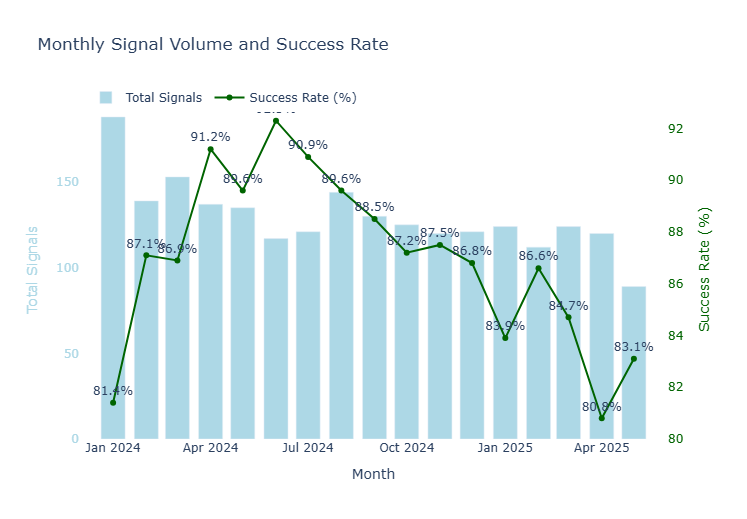

In [18]:
import plotly.graph_objects as go
from pathlib import Path

# === Bar + Line Combo Chart: Total signals and Success Rate ===
fig = go.Figure()

# Bar: total signals
fig.add_trace(go.Bar(
    x=monthly_summary["month"],
    y=monthly_summary["total_signals"],
    name="Total Signals",
    marker_color="lightblue",
    yaxis="y1"
))

# Line: success rate
fig.add_trace(go.Scatter(
    x=monthly_summary["month"],
    y=monthly_summary["success_rate"],
    name="Success Rate (%)",
    mode="lines+markers+text",
    text=[f"{v:.1f}%" for v in monthly_summary["success_rate"]],
    textposition="top center",
    marker=dict(color="darkgreen"),
    yaxis="y2"
))

fig.update_layout(
    title="Monthly Signal Volume and Success Rate",
    xaxis_title="Month",
    yaxis=dict(
        title="Total Signals",
        titlefont=dict(color="lightblue"),
        tickfont=dict(color="lightblue"),
        side="left"
    ),
    yaxis2=dict(
        title="Success Rate (%)",
        titlefont=dict(color="darkgreen"),
        tickfont=dict(color="darkgreen"),
        overlaying="y",
        side="right"
    ),
    bargap=0.2,
    width=900,
    height=500,
    legend=dict(x=0.01, y=1.05, orientation="h"),
    plot_bgcolor="white"
)

# Save chart as HTML
output_path = Path("../outputs/plots/monthly_signal_volume_success_rate.html")
fig.write_html(output_path)

# Optional: display inline (Jupyter)
fig.show()


This chart shows the total number of trading signals per month (bars) and the corresponding success rate (line). Despite fluctuations in volume, the success rate remained relatively stable, with some noticeable drops in early 2025

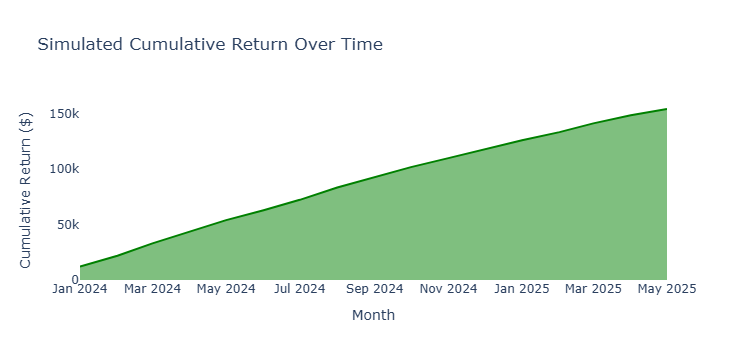

In [15]:
# Load cleaned performance summary
df_monthly = pd.read_csv("../data/clean/monthly_signal_performance.csv")

# Create cumulative return column
df_monthly["cumulative_return"] = df_monthly["total_monthly_return"].cumsum()

# Plot cumulative return as a stacked area chart
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_monthly["month"],
    y=df_monthly["cumulative_return"],
    mode="lines",
    fill="tozeroy",
    line=dict(color="green"),
    name="Cumulative Return"
))

fig.update_layout(
    title="Simulated Cumulative Return Over Time",
    xaxis_title="Month",
    yaxis_title="Cumulative Return ($)",
    plot_bgcolor="white"
)

fig.show()

# === Save chart as HTML ===
output_path = Path("../outputs/plots/monthly_return_line_chart.html")
output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
fig.write_html(str(output_path), include_plotlyjs="cdn")



In [21]:
n_months = df_returns["timestamp"].dt.to_period("M").nunique()
print(f"Total months in simulation: {n_months}")

Total months in simulation: 17


C:\Users\PcVIP\AppData\Local\Temp\ipykernel_18796\1656569514.py:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



C:\Users\PcVIP\AppData\Local\Temp\ipykernel_18796\3853223227.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



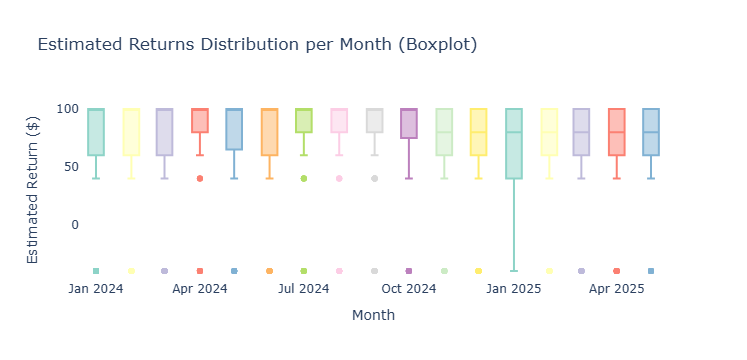

In [31]:
# Load cleaned signals data with estimated returns 
df = pd.read_csv("../data/clean/signals_tp_clean_with_returns.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Create boxplot chart 
fig = px.box(
    df,
    x="month",
    y="estimated_return",
    color="month",
    title="Estimated Returns Distribution per Month (Boxplot)",
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Estimated Return ($)",
    plot_bgcolor="white",
    showlegend=False
)

# Save chart as HTML 
output_path = Path("../outputs/plots/returns_histogram_by_month.html")
output_path.parent.mkdir(parents=True, exist_ok=True)
fig.write_html(str(output_path), include_plotlyjs="cdn")

# Show in notebook
fig.show()

This boxplot shows the monthly distribution of returns based on a $100 investment per signal.

Some months have more consistent returns, others are volatile.

Negative returns are common in some periods.

Outliers highlight occasional high or low performances.

In [33]:
# Load the cleaned data with estimated returns
df = pd.read_csv("../data/clean/signals_tp_clean_with_returns.csv", parse_dates=["timestamp"])

# Extract month
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Group by month and direction
long_short_summary = df.groupby(["month", "direction"]).agg(
    total_signals=("estimated_return", "count"),
    avg_return=("estimated_return", "mean"),
    total_return=("estimated_return", "sum")
).reset_index()

# Round results
long_short_summary["avg_return"] = long_short_summary["avg_return"].round(2)
long_short_summary["total_return"] = long_short_summary["total_return"].round(2)

# Show the table
print(long_short_summary)


      month direction  total_signals  avg_return  total_return
0   2024-01      Long            106       63.96          6780
1   2024-01     Short             82       64.15          5260
2   2024-02      Long             88       77.27          6800
3   2024-02     Short             51       58.82          3000
4   2024-03      Long             94       70.21          6600
5   2024-03     Short             59       77.97          4600
6   2024-04      Long             60       73.00          4380
7   2024-04     Short             77       83.12          6400
8   2024-05      Long             81       81.98          6640
9   2024-05     Short             54       66.30          3580
10  2024-06      Long             43       56.74          2440
11  2024-06     Short             74       88.65          6560
12  2024-07      Long             67       77.01          5160
13  2024-07     Short             54       77.04          4160
14  2024-08      Long             55       71.64       

C:\Users\PcVIP\AppData\Local\Temp\ipykernel_18796\4267185788.py:5: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



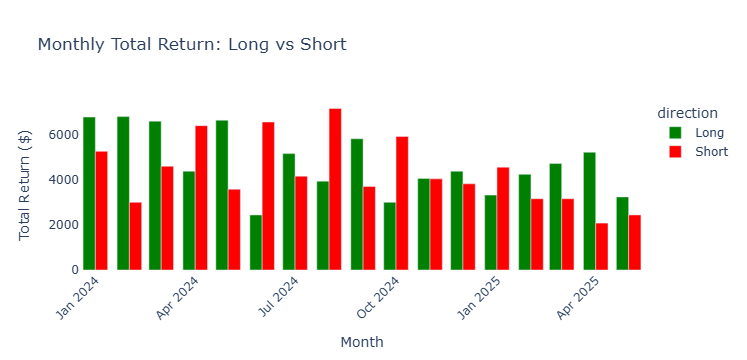

In [34]:

# Create grouped bar chart
fig = px.bar(
    long_short_summary,
    x="month",
    y="total_return",
    color="direction",
    barmode="group",
    title="Monthly Total Return: Long vs Short",
    labels={"total_return": "Total Return ($)", "month": "Month"},
    color_discrete_map={"Long": "green", "Short": "red"}
)

fig.update_layout(
    plot_bgcolor="white",
    xaxis_tickangle=-45
)

# Save as HTML
output_path = Path("../outputs/plots/monthly_total_return_long_short.html")
output_path.parent.mkdir(parents=True, exist_ok=True)
fig.write_html(str(output_path), include_plotlyjs="cdn")

# Display in notebook
fig.show()

This chart highlights the monthly total return comparison between Long and Short signals. In most months, Long signals outperformed Short signals in terms of cumulative returns, suggesting that Long strategies were generally more profitable during this period. However, there are months where Short signals achieved higher returns, indicating that directional effectiveness can vary depending on market conditions.